# Adathalmaz inportálása, szükséges oszlopok kiszedése, szövegtisztítás

In [225]:
import numpy as np
import pandas as pd

In [226]:
df = pd.read_csv("kindle_reviews.csv")
df["reviewText"] = df["reviewText"].astype(str)
df.head()

,Unnamed: 0,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0,B000F83SZQ,"[0, 0]",5,I enjoy vintage books and movies so I enjoyed ...,"05 5, 2014",A1F6404F1VG29J,Avidreader,Nice vintage story,1399248000
1,1,B000F83SZQ,"[2, 2]",4,This book is a reissue of an old one; the auth...,"01 6, 2014",AN0N05A9LIJEQ,critters,Different...,1388966400
2,2,B000F83SZQ,"[2, 2]",4,This was a fairly interesting read. It had ol...,"04 4, 2014",A795DMNCJILA6,dot,Oldie,1396569600
3,3,B000F83SZQ,"[1, 1]",5,I'd never read any of the Amy Brewster mysteri...,"02 19, 2014",A1FV0SX13TWVXQ,"Elaine H. Turley ""Montana Songbird""",I really liked it.,1392768000
4,4,B000F83SZQ,"[0, 1]",4,"If you like period pieces - clothing, lingo, y...","03 19, 2014",A3SPTOKDG7WBLN,Father Dowling Fan,Period Mystery,1395187200


In [227]:
del df['Unnamed: 0']
del df['asin']
del df['helpful']
del df['reviewTime']
del df['reviewerID']
del df['reviewerName']
del df['unixReviewTime']
del df['summary']


In [228]:
df["reviewText"] = df["reviewText"].apply(lambda review_text: review_text.lower().replace('.', '').replace(',', '').replace('?', '').replace('!', '').replace("'s", "").replace("n't", "").replace(";","").replace("'d",""))

In [229]:
df.head()

,overall,reviewText
0,5,i enjoy vintage books and movies so i enjoyed ...
1,4,this book is a reissue of an old one the autho...
2,4,this was a fairly interesting read it had old...
3,5,i never read any of the amy brewster mysteries...
4,4,if you like period pieces - clothing lingo you...


In [230]:
import nltk

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adaml\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [231]:
from nltk.corpus import stopwords
import os
import string 
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [232]:
print(stop)

{'haven', "won't", 'each', 'hadn', 'we', "you'd", '~', 'on', 'myself', '"', 'most', 'can', ')', 'doing', 'be', 'her', 'into', "should've", 'until', 'because', 'what', 'between', 's', 'own', "hasn't", 'me', 'my', '.', 'hers', 'your', 'had', 'yourselves', 'itself', 'or', 'any', 'of', 'nor', 'just', 'than', 'does', 'for', 'about', 'is', "weren't", 'here', ':', 'whom', 'it', 'have', 'm', "'", '+', "she's", 'some', 'below', 'wasn', 'while', 'wouldn', 'do', 't', 'were', 'didn', 'out', "you'll", 'from', 'more', 'will', 'mightn', '?', 'being', 'don', 'you', 'she', 'its', 'the', "wouldn't", '=', ',', 'they', '<', '$', 'down', 'as', 've', 'through', 'that', 'shouldn', "wasn't", 'our', '{', 'an', 'once', '@', "that'll", 'theirs', 'such', 'should', 'needn', 'isn', 'by', '/', '#', 'against', 'very', 'did', 'i', '&', 'with', 'off', 'where', "mightn't", 'ourselves', "you've", 'he', 'too', "haven't", 'then', 'his', "don't", '`', 'those', 'over', 'after', "shouldn't", 'before', 'ain', 'him', 'so', "isn

In [233]:
def clean_text(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            word = i.strip().lower()
            final_text.append(word)
    return " ".join(final_text)

In [234]:
df["reviewText"] = df["reviewText"].apply(clean_text)

In [235]:
df.head()

,overall,reviewText
0,5,enjoy vintage books movies enjoyed reading boo...
1,4,book reissue old one author born 1910 era say ...
2,4,fairly interesting read old- style terminology...
3,5,never read amy brewster mysteries one really h...
4,4,like period pieces clothing lingo enjoy myster...


In [236]:
df.overall.value_counts()

5    575264
4    254013
3     96194
2     34130
1     23018
Name: overall, dtype: int64

# Tokenizáció

In [237]:
from tokenizers import BertWordPieceTokenizer

tokenizer = BertWordPieceTokenizer("../data/bert-base-uncased-vocab.txt",
                                   lowercase=True)

def bert_tokenizer(data):
    result = []
    for item in data:
        result.append(tokenizer.encode(item).ids)
    
    return np.array(result, dtype=object)

In [238]:
def review_sentiment(rating):   
     if(rating == 1 or rating == 2):
        return 1
     elif rating == 3:
        return 2
     elif  (rating == 4 or rating == 5):
        return 3

In [239]:
df.overall = df.overall.apply(review_sentiment)

In [240]:
print("pozítívak", df[df["overall"] == 3].count())
print("semlegesek", df[df["overall"] == 2].count())
print("negatívak", df[df["overall"] == 1].count())

pozítívak overall       829277
reviewText    829277
dtype: int64
semlegesek overall       96194
reviewText    96194
dtype: int64
negatívak overall       57148
reviewText    57148
dtype: int64


# Train, validation és test adathalmazok létrehozása

In [241]:
len_df = len(df)
print(len_df)

len_train = int(round(len_df * 0.6))
len_val_test = (len_df - len_train) // 4
len_train = len_train // 2

print(len_train)
print(len_val_test)

982619
294785
98262


In [242]:
df_3 = df[df['overall'] == 3].copy()
df_2 = df[df['overall'] == 2].copy()
df_1 = df[df['overall'] == 1].copy()

len_train_1 = int(df_1.shape[0] * 0.8)
len_train_2 = int(df_2.shape[0] * 0.6)
len_train_3 = int(df_3.shape[0] * 0.1)

len_val_1 = (df_1.shape[0] - len_train_1) // 4
len_val_2 = (df_2.shape[0] - len_train_2) // 20
len_val_3 = (df_3.shape[0] - len_train_3) // 100

len_test_1 = len_train_1 // 2
len_test_2 = len_train_2 // 6
len_test_3 = len_train_3 // 8

In [243]:
print(len_test_1)

22859


In [244]:
df_1_train = df_1.iloc[:len_train_1].copy()
df_2_train = df_2.iloc[:len_train_2].copy()
df_3_train = df_3.iloc[:len_train_3].copy()

df_1_val = df_1.iloc[len_train_1:len_train_1+len_val_1].copy()
df_2_val = df_2.iloc[len_train_2:len_train_2+len_val_2].copy()
df_3_val = df_3.iloc[len_train_3:len_train_3+len_val_3].copy()

df_1_test = df_1.iloc[len_train_1+len_val_1:len_train_1+len_val_1+len_test_1].copy()
df_2_test = df_2.iloc[len_train_2+len_val_2:len_train_2+len_val_2+len_test_2].copy()
df_3_test = df_3.iloc[len_train_3+len_val_3:len_train_3+len_val_3+len_test_3].copy()

In [245]:
print(len(df_2_test))

9619


In [246]:
df_3_train[:len_train]

,overall,reviewText
0,3,enjoy vintage books movies enjoyed reading boo...
1,3,book reissue old one author born 1910 era say ...
2,3,fairly interesting read old- style terminology...
3,3,never read amy brewster mysteries one really h...
4,3,like period pieces clothing lingo enjoy myster...
...,...,...
107611,3,first time read anything author impressed work...
107612,3,book kept intrigued beginningi wish went futur...
107613,3,little gem sweet romance well-written read lik...
107614,3,got say found new favorite author like style m...


array([[<AxesSubplot:title={'center':'overall'}>]], dtype=object)

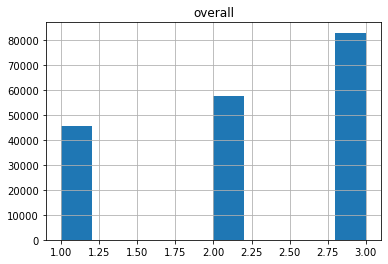

In [247]:
df_train = pd.concat([df_1_train, df_2_train, df_3_train])
df_train = df_train.sample(frac=1)
df_train.hist()

In [248]:
df_1_val.head()

,overall,reviewText
678991,1,started good visit frank made india old story ...
679045,1,really wanted like one football players geeks ...
679055,1,read story get tommy tavio exactly lovers hard...
679100,1,got confusing got lost 3rd chapter would like ...
679101,1,bad book well written good romance something m...


array([[<AxesSubplot:title={'center':'overall'}>]], dtype=object)

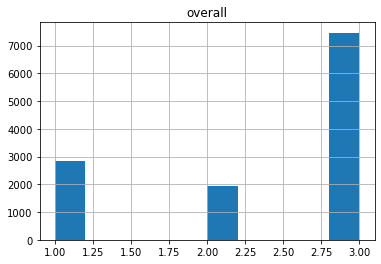

In [249]:
df_val = pd.concat([df_1_val, df_2_val, df_3_val])
df_val = df_val.sample(frac=1)
df_val.hist()

array([[<AxesSubplot:title={'center':'overall'}>]], dtype=object)

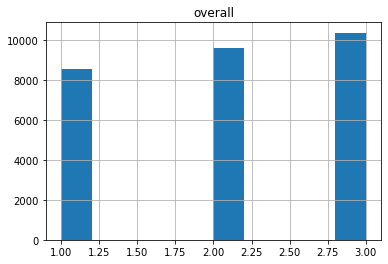

In [250]:
df_test = pd.concat([df_1_test, df_2_test, df_3_test])
df_test = df_test.sample(frac=1)
df_test.hist()

In [251]:
df_val.head()

,overall,reviewText
502960,2,it&#8217s short novella real character buildin...
107815,3,alexa warriors looking fabled safe haventhey b...
107710,3,elementary school teacher see children labelle...
494093,2,like dimitri lot derry much book constant sex ...
499912,2,know say story gruesome point funny sick old b...


# Multiklasszifikáció

In [252]:
import tensorflow as tf

maxlen = 128

X_train = list(df_train["reviewText"].values)
X_train = bert_tokenizer(X_train)
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
y_train = df_train["overall"].values

X_val = list(df_val["reviewText"].values)
X_val = bert_tokenizer(X_val)
X_val = tf.keras.preprocessing.sequence.pad_sequences(X_val, maxlen=maxlen)
y_val = df_val["overall"].values


X_test = list(df_test["reviewText"].values)
X_test = bert_tokenizer(X_test)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
y_test = df_test["overall"].values

In [253]:
import tensorflow as tf

emb_size = 32
max_features = 30523 # vocab size

model_simple_rnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, emb_size, input_length=maxlen),
    tf.keras.layers.SimpleRNN(units=emb_size, activation='tanh'),
    tf.keras.layers.Dense(units=4, activation='softmax')
]) 

model_simple_rnn.compile(optimizer='adam',
                         loss="sparse_categorical_crossentropy",
                         metrics=['accuracy'])

model_simple_rnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 128, 32)           976736    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 132       
Total params: 978,948
Trainable params: 978,948
Non-trainable params: 0
_________________________________________________________________


In [254]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)

h_simple_rnn = model_simple_rnn.fit(X_train, 
                                    y_train,
                                    epochs=5,
                                    batch_size=32,
                                    callbacks=[callback],
                                    validation_data=(X_val, y_val))

Epoch 1/5
5824/5824 [==============================] - 141s 24ms/step - loss: 0.8810 - accuracy: 0.5785 - val_loss: 0.6587 - val_accuracy: 0.7309
Epoch 2/5
5824/5824 [==============================] - 138s 24ms/step - loss: 0.6442 - accuracy: 0.7221 - val_loss: 0.6503 - val_accuracy: 0.7399
Epoch 3/5
5824/5824 [==============================] - 136s 23ms/step - loss: 0.6086 - accuracy: 0.7398 - val_loss: 0.6150 - val_accuracy: 0.7450
Epoch 4/5
5824/5824 [==============================] - 139s 24ms/step - loss: 0.5898 - accuracy: 0.7500 - val_loss: 0.6701 - val_accuracy: 0.7197
Epoch 5/5
5824/5824 [==============================] - 136s 23ms/step - loss: 0.5534 - accuracy: 0.7709 - val_loss: 0.6603 - val_accuracy: 0.7258


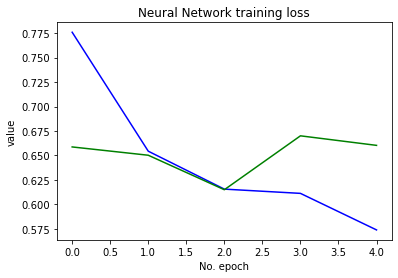

In [255]:
import matplotlib.pyplot as plt

plt.plot(h_simple_rnn.history['loss'], label='(training data)',color='blue')
plt.plot(h_simple_rnn.history['val_loss'], label='(val data)',color='green')
plt.title('Neural Network training loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.show()

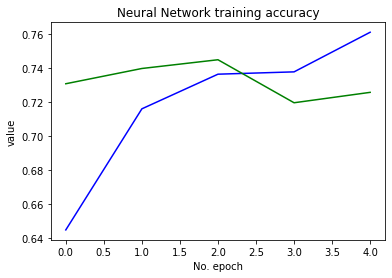

In [256]:
import matplotlib.pyplot as plt

plt.plot(h_simple_rnn.history['accuracy'], label='(training data)',color='blue')
plt.plot(h_simple_rnn.history['val_accuracy'], label='(val data)',color='green')
plt.title('Neural Network training accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.show()

In [257]:
results = model_simple_rnn.evaluate(X_test, y_test, batch_size=32)
print("Simple rnn test loss, test acc:", results)

893/893 [==============================] - 4s 4ms/step - loss: 0.7567 - accuracy: 0.6733
Simple rnn test loss, test acc: [0.7566514015197754, 0.6733200550079346]


In [258]:
import tensorflow as tf

emb_size = 32
max_features = 30523 # vocab size

model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, emb_size, input_length=maxlen),
    tf.keras.layers.LSTM(units=emb_size, activation='tanh'),
    tf.keras.layers.Dense(units=4, activation='softmax')
]) 

model_lstm.compile(optimizer='adam',
                   loss="sparse_categorical_crossentropy",
                   metrics=['accuracy'])

model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 128, 32)           976736    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 132       
Total params: 985,188
Trainable params: 985,188
Non-trainable params: 0
_________________________________________________________________


In [259]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)

h_lstm = model_lstm.fit(X_train, 
                        y_train,
                        epochs=4,
                        batch_size=64,
                        callbacks=[callback],
                        validation_data=(X_test, y_test))

Epoch 1/4
2912/2912 [==============================] - 170s 57ms/step - loss: 0.8018 - accuracy: 0.6268 - val_loss: 0.6712 - val_accuracy: 0.7000
Epoch 2/4
2912/2912 [==============================] - 161s 55ms/step - loss: 0.5983 - accuracy: 0.7403 - val_loss: 0.6434 - val_accuracy: 0.7140
Epoch 3/4
2912/2912 [==============================] - 163s 56ms/step - loss: 0.5419 - accuracy: 0.7672 - val_loss: 0.6602 - val_accuracy: 0.7115
Epoch 4/4
2912/2912 [==============================] - 164s 56ms/step - loss: 0.4949 - accuracy: 0.7917 - val_loss: 0.6735 - val_accuracy: 0.7075


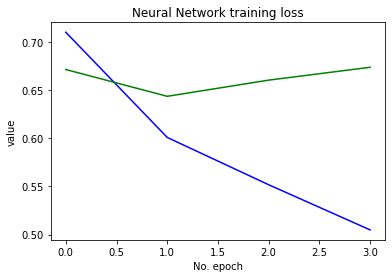

In [260]:
import matplotlib.pyplot as plt

plt.plot(h_lstm.history['loss'], label='(training data)',color='blue')
plt.plot(h_lstm.history['val_loss'], label='(val data)',color='green')
plt.title('Neural Network training loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.show()

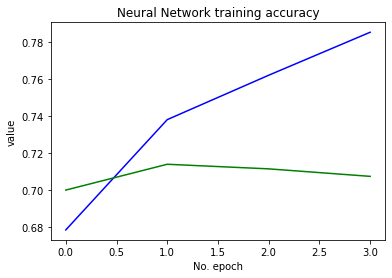

In [261]:
import matplotlib.pyplot as plt

plt.plot(h_lstm.history['accuracy'], label='(training data)',color='blue')
plt.plot(h_lstm.history['val_accuracy'], label='(val data)',color='green')
plt.title('Neural Network training accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.show()

In [262]:
results = model_lstm.evaluate(X_test, y_test, batch_size=32)
print("LSTM test loss, test acc:", results)

893/893 [==============================] - 8s 9ms/step - loss: 0.6735 - accuracy: 0.7075
LSTM test loss, test acc: [0.6734805703163147, 0.7074622511863708]


# Vektor valami cucc

In [263]:
lista = df_train.values.tolist()
train_bad_review = []
train_neutral_review = []
train_good_review = []

for overall, szoveg in lista:
    if overall == 1:
        for szo in szoveg.split():
            train_bad_review.append(szo)
    elif overall == 2:
        for szo in szoveg.split():
            train_neutral_review.append(szo)
    else:
        for szo in szoveg.split():
            train_good_review.append(szo)

In [264]:
def keres(szo):
    jo = train_good_review.count(szo)
    kozep = train_neutral_review.count(szo)
    rossz = train_bad_review.count(szo)

    osszeg = jo+ rossz+ kozep
    jo_e = round(jo/osszeg*100, 2)
    n_e = round(kozep/osszeg*100, 2)
    rossz_e = round(rossz/osszeg*100, 2)

    if max(jo, kozep, rossz) == jo:
        mi = "pozitív értékelés"
    elif max(jo, kozep, rossz) == kozep:
        mi = "semleges értékelés"
    else:
        mi = "negatív értékelés"

    return f"Jó találatok: {jo}; közepes találatok: {kozep}, rossz találatok: {rossz},\nJó lehet  {jo_e}% eséllyel\nSemleges lehet {n_e}% eséllyel\nRossz review lehet {rossz_e}% eséllyel.\n\nA szó besorolása {mi}ű"

In [265]:
print(keres("fine"))

Jó találatok: 927; közepes találatok: 978, rossz találatok: 679,
Jó lehet  35.87% eséllyel
Semleges lehet 37.85% eséllyel
Rossz review lehet 26.28% eséllyel.

A szó besorolása semleges értékelésű
